Link to data: https://figshare.com/articles/brain_tumor_dataset/1512427

Link to basic Tutorial about this data: https://medium.com/@seymatas/pytorch-image-segmentation-tutorial-for-beginners-i-88d07a6a63e4

A Broef Data Description:

* cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor  

* cjdata.PID: patient ID  

* cjdata.image: image data  

* cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border. We can use it to generate a binary image of the tumor mask.  

* cjdata.tumorMask: a binary image with 1s indicating tumor region  

## Baseline Model

## Check the data
* The images are not perfectly centered and some of them are slightly rotated
* There are some images that needed reshaping because they had no boundaries at all (they also need scaling, there 15 such images)
* For some images tumor boardes are not acccurately contoured in mask dataset (example img 1075)

In [1]:
# https://github.com/qubvel/segmentation_models#installation
# ! pip install -U segmentation-models-pytorch
# !pip uninstall -y segmentation-models-pytorch

In [2]:
import sys
from pathlib import Path
sys.path.append('../')

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import segmentation_models_pytorch as sm
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
sns.set()

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [4]:
def plot_images(imgs, names=None, axs=None, show=True, nrows=None, ncols=None, figsize=(16, 8)):
    from math import ceil
    if nrows is None and ncols is None:
        nrows = 1
        ncols = len(imgs)
    elif nrows is None:
        nrows = ceil(len(imgs) / ncols)
    elif ncols is None:
        ncols = ceil(len(imgs) / nrows)
    
    if axs is None:
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    if nrows == 1 and ncols == 1:
        axs.imshow(imgs[0])
        axs.set_axis_off()
        if names and len(names) > 0:
            axs.set_title(names[0], fontsize=15)
    elif nrows == 1 or ncols == 1:
        for j, ax in enumerate(axs):
            ax.imshow(imgs[j])
            ax.set_axis_off()
            if names and j < len(names):
                ax.set_title(names[j], fontsize=15)
    else:
        for j, ax in enumerate(axs):
            for k, sub_ax in enumerate(ax):
                image_id = j * ncols + k
                sub_ax.set_axis_off()
                if image_id < len(imgs):
                    sub_ax.imshow(imgs[image_id])
                    if names and image_id < len(names):
                        sub_ax.set_title(names[image_id], fontsize=15)
    if show:
        plt.show()

In [31]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(self, path_to_dir, path_to_csv,
                 augmentation=None, preprocessing=None):
        self.path_to_dir = Path(path_to_dir)
        self.csv = pd.read_csv(self.path_to_dir / path_to_csv)
        self.csv['path'] = self.csv['path'].apply(lambda x: self.path_to_dir / x)
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def get_raw(self, i):
        opened = h5py.File(self.csv.iloc[i].path, mode='r').get('cjdata')
        image = opened.get('image')[()]
        mask = opened.get('tumorMask')[()]
        label = int(opened.get('label')[()][0, 0] - 1)
        
        if image.ndim == 2:
            image = image[..., None]
        if image.dtype == 'int16':
            image = (image/(2**8)).astype('uint8')
        mask = mask
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask, label
    
    def __getitem__(self, i):
        image, mask, label = self.get_raw(i)
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask.float(), label
#         return image, mask.float()
        
    def __len__(self):
        return len(self.csv)

In [6]:
def trunc_paths(path):
    start, *parts = path.parts[3:]
    return Path(start).joinpath(*parts)

In [7]:
path_to_files = Path('../../data/')
# all_files = sorted(path_to_files.glob('all_brain_tumors/*.mat'), key=lambda x: int(x.stem))
# df_all = pd.DataFrame(all_files, columns=['path'])
# df_all.path = df_all.path.apply(trunc_paths)
# df_train, df_valid = train_test_split(df_all, test_size=0.15)

# df_all.to_csv(path_to_files / 'data_all.csv', index=False)
# df_train.to_csv(path_to_files / 'data_train.csv', index=False)
# df_valid.to_csv(path_to_files / 'data_valid.csv', index=False)

In [8]:
import albumentations.augmentations.functional as F
from albumentations import ImageOnlyTransform, Resize, Compose
from albumentations.pytorch import ToTensorV2
import albumentations as albu

In [9]:
class InstanceNormalize(ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1.0):
        super().__init__(always_apply, p)

    def apply(self, image, **params):
        mean = image.mean(axis=(0, 1), keepdims=True)
        std = image.mean(axis=(0, 1), keepdims=True)
        std[std == 0] = 1
        return F.normalize(image, mean, std, 1)

    def get_transform_init_args_names(self):
        return ()

In [34]:
desired_shape = (512, 512)

In [84]:
def get_training_augmentation(target_shape):
    train_transform = [
        albu.VerticalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.3, rotate_limit=90, shift_limit=0.1, p=0.8, border_mode=0, mask_value=0, value=0),
        albu.RandomResizedCrop(height=desired_shape[0], width=desired_shape[1], scale=[0.5, 1]),
#         albu.PadIfNeeded(min_height=desired_shape[0], min_width=desired_shape[1], border_mode=0, mask_value=0),
        albu.Resize(height=desired_shape[0], width=desired_shape[1]),

#         albu.HorizontalFlip(p=0.5),

#         albu.RandomCrop(height=desired_shape[0], width=desired_shape[1], always_apply=True),
        
        albu.OneOf(
            [
              albu.ElasticTransform(p=1, alpha_affine=0.05),
              albu.GridDistortion(p=1, distort_limit=0.2)  
            ],
            p=0.7
        )

    ]
    return albu.Compose(train_transform)

In [85]:
preprocessing = Compose([
    Resize(desired_shape[0], desired_shape[1]),
    InstanceNormalize(),
    ToTensorV2()
])

In [86]:
train_dataset = Dataset(path_to_files, 'data_train.csv', preprocessing=preprocessing, augmentation = get_training_augmentation(desired_shape))
valid_dataset = Dataset(path_to_files, 'data_valid.csv', preprocessing=preprocessing, augmentation = get_training_augmentation(desired_shape))

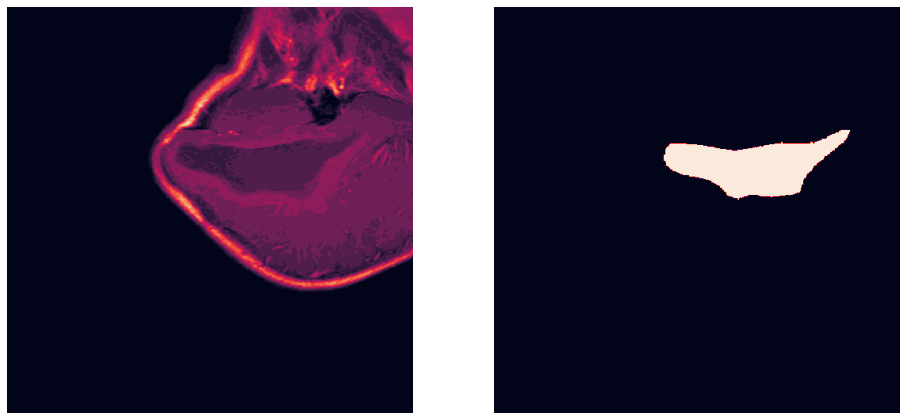

In [93]:
plot_images(train_dataset.get_raw(255)[:2])

In [28]:
i, m, l = train_dataset[0]

In [30]:
l

2.0

## Model Training

Copypasted from Segmentation_models tutorial   

https://github.com/qubvel/segmentation_models#installation

In [14]:
ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = None
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.2,               # dropout ratio, default is None
    activation='sigmoid',      # activation function, default is None
    classes=3,                 # define number of output labels
)

# create segmentation model with pretrained encoder
model = sm.Unet(
    in_channels=1,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
    aux_params=None
)

In [15]:
from segmentation_models_pytorch.utils import losses, base

In [16]:
# loss = base.SumOfLosses(losses.DiceLoss(), losses.CrossEntropyLoss())
loss = losses.BCELoss()
metrics = [
    sm.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

In [17]:
train_dataset = Dataset(path_to_files, 'data_train.csv', preprocessing=preprocessing, augmentation = get_training_augmentation(desired_shape))
valid_dataset = Dataset(path_to_files, 'data_valid.csv', preprocessing=preprocessing, augmentation = get_training_augmentation(desired_shape))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4)

train_epoch = sm.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = sm.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [18]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/326 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/training_pipeline/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([8, 512, 512])) that is different to the input size (torch.Size([8, 1, 512, 512])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


train:  26%|██▋       | 86/326 [00:59<02:45,  1.45it/s, bce_loss - 0.2263, iou_score - 0.04345]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/training_pipeline/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-0db0875a4c35>", line 8, in <module>
    train_logs = train_epoch.run(train_loader)
  File "/home/ubuntu/miniconda3/envs/training_pipeline/lib/python3.7/site-packages/segmentation_models_pytorch/utils/train.py", line 47, in run
    loss, y_pred = self.batch_update(x, y)
  File "/home/ubuntu/miniconda3/envs/training_pipeline/lib/python3.7/site-packages/segmentation_models_pytorch/utils/train.py", line 90, in batch_update
    self.optimizer.step()
  File "/home/ubuntu/miniconda3/envs/training_pipeline/lib/python3.7/site-packages/torch/autograd/grad_mode.py", line 15, in decorate_context
    return func(*args, **kwargs)
  File "/home/ubuntu/miniconda3/envs/training_pipeline/lib/python3.7/site-packages/torch/optim/adam.py", line 100, in s

TypeError: object of type 'NoneType' has no len()

IoU score was reducing crucially, hence, we have stopped the training

## Datasets without tumors

* ~150 healthy suggital images https://figshare.com/articles/dataset/t1_nii/7853405
* https://figshare.com/articles/dataset/Brain_1_MRI_NIfTI_format_/6068177
* https://figshare.com/articles/dataset/Brain_2_MRI_NIfTI_format_/6068171


22 Axial images but they are dicom https://www.kaggle.com/ilknuricke/neurohackinginrimages
~100 negative cases but they are pictures https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection? 
